## Using MELTS and MAGEMin as liquid-only thermometers (finding liquidus temperatures)

Prior to starting any calculations it is necessary to load the relevant packages. As most of the work is done in the pyMELTScalc functions, only a few packages need to be imported into your notebook. These include $numpy$ and $pandas$ (for data processing), $matplotlib.pyplot$ for the visualisation of results, and $pyMELTScalc$ itself. In addition, it is necessary to append the path to the alphaMELTS for MATLAB/Python packages (available via GitLab), which are done using $sys$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyMELTScalc as M

import sys
sys.path.append(r'H:\My Drive\2022\GitHub\pyMELTScalc\MELTS')

To test the ability of MELTS and MAGEMin to act at liquid-only thermometers we need some experiments to test them against. Here, we use a database of experimental data compiled by P. Wieser and isolate all the melt compositions in the $Liq$ sheet. 

In [2]:
Data = pd.read_excel('LEPR_Wet_stitched_Sept2022.xlsx', sheet_name = 'Liq')

The entire experimental dataset contains over 2000 samples. Therefore, to reduce the computational time in this example spreadsheet I isolate 200 experiments (randomly selected) to be used in the following calculations. A new DataFrame is constructed using only these experiments.

In [3]:
# randomly select 200 rows from the original DataFrame
Ch = np.random.choice(range(len(Data['SiO2_Liq'])), 200, replace=False)
Test = Data.copy()
Test = Test.loc[Ch]

# reset the index in the new DataFrame
Test = Test.reset_index(drop = True)

Now that we have this 'Test' DataFrame we can use the findLiq_multi function to identify the liquidus temperature of each sample. Ideally, we'd have information about either the Fe redox state or an estimate of the oxygen fugacity of each melt. Unfortunately, we don't have this information for every sample so instead we will define a constant Fe$^{3+}$/Fe$_{tot}$ ratio for all samples:

In [4]:
Results_pMELTS = M.findLiq_multi(Model = "pMELTS", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

  0%|          | 0/25 [00:00<?, ?it/s]

Examining the results demonstrates the information that is recorded by this code. Notably, the findLiq_multi code will return the composition of the melt at the liquidus (in wt% hydrous normalized), whether or not the melt is fluid saturated at the liquidus, the liquidus phase and (critically) the liquidus temperature (in degrees Celsius).

In [ ]:
Results_pMELTS.head()

T_Liq liquidus_phase fluid_saturated   SiO2_Liq  TiO2_Liq  Al2O3_Liq   
0   873.3   plagioclase1              No  70.622805  0.103167  14.227728  \
1   900.9   plagioclase1              No  68.496564  0.254106  13.777153   
2  1099.6       olivine1              No  59.694534  0.876362  15.692997   
3  1153.0       olivine1              No  57.210401  1.541055  14.806213   
4  1172.8       olivine1              No  49.221318  0.700382  16.828632   

    FeOt_Liq   MnO_Liq   MgO_Liq    CaO_Liq  Na2O_Liq   K2O_Liq  P2O5_Liq   
0   0.722104  0.046894  0.628384   1.275525  3.751543  2.888688       0.0  \
1   2.046362  0.033067  0.344220   1.946461  4.339053  2.978228       0.0   
2   4.232616  0.040761  4.952466   5.105320  4.157625  1.661012       0.0   
3  10.474160  0.130939  4.693670   7.413179  2.276329  1.279176       0.0   
4  10.018418  0.145913  8.171128  10.019359  1.799594  0.301554       0.0   

    H2O_Liq  CO2_Liq  
0  5.721104      0.0  
1  5.750620      0.0  
2  3.515639      0.0  
3  0.000000      0.0  
4  2.626434      0.0

In this initial calculation, the liquidus temperature is calculated using the pMELTS model, which was designed for use on mantle-like bulk compositions at 1 - 3 GPa (Ghiorso et al. 2002). For the majorty of samples in this database it may be more appropriate to use the rhyoliteMELTSv1.0.2 (Gualda et al. 2012) or rhyoliteMELTSv1.2.0 (Ghiorso and Gualda, 2015) models. We can rerun the same calculations but change the Model selected:

In [ ]:
Results_MELTSv102 = M.findLiq_multi(Model = "MELTSv1.0.2", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

In [ ]:
Results_MELTSv120 = M.findLiq_multi(Model = "MELTSv1.2.0", # which MELTS model to use - "pMELTS", "MELTSv1.0.2", "MELTSv1.1.0", or "MELTSv1.2.0"
                        bulk = Test, # initial composition(s) wither a dictionary (if one composition) or a DataFrame (multiple compositions)
                        T_initial_C = Test['T_K'].values-200, # Initial guess for the liquidus temperature (optional)
                        P_bar = Test['P_kbar'].values*1000, # Pressure (in bars) of the calculation
                        Fe3Fet_Liq = 0.15) # initial Fe3Fet_Liq ratio of the sample(s)

Now that we have the results of this analysis, we can compare the results of these calculations to the true experimental temperature. Experiments that have no reported water typically show a very poor match to the experimental temperature, and are thus excluded from the following comparison. Additionally, we exlude any calculations that did not return a result (Results['T_C_liq'] = 0).

Overall, MELTS does an acceptable job in reproducing the experimental temperatures, although it is notable that the liquidus temperature is typically overpredicted by around 50 $^{o}$C.

Text(0.5, 0, 'Experimental Temperature ($^{o}$C)')

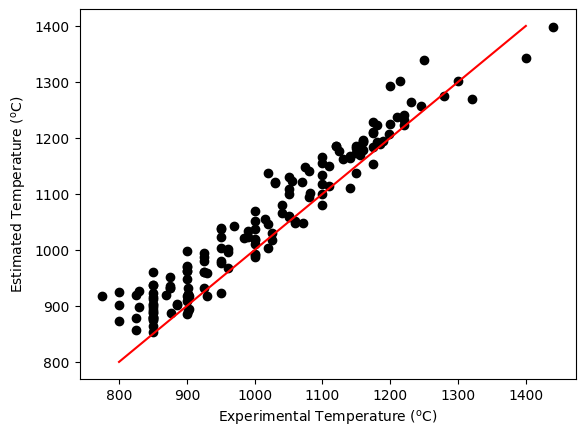

In [9]:
f, a = plt.subplots(1,1)
a.plot(Test['T_K'][(Test['H2O_Liq'] > 0) & (Results['T_Liq'] > 0)]-273.15,
       Results['T_Liq'][(Test['H2O_Liq'] > 0) & (Results['T_Liq'] > 0)], 
        'ok')
a.plot([800,1400],[800,1400], 'r-')
a.set_ylabel('Estimated Temperature ($^{o}$C)')
a.set_xlabel('Experimental Temperature ($^{o}$C)')